## Procesamiento de Imágenes - Diplodatos 2024

Trabajo Práctico

Importante: Para obtener los créditos de materia completa, resolver al menos 1 ejercicio optativo de cada trabajo práctico.


In [1]:
integrantes = ["Emanuel Nicolás Herrador", "Juan Cruz Gonzalez", "Griselda Itovich"]
print(*integrantes, sep="\n")

Emanuel Nicolás Herrador
Juan Cruz Gonzalez
Griselda Itovich


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Importar las librerías necesarias


In [3]:
import imageio as iio
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import widgets
from scipy import ndimage as ndi
%matplotlib inline
from skimage.color import rgb2gray
from skimage.transform import rescale

Abrir imágenes de demo incluídas en la biblioteca de imageio. Para evitar cargar desde disco, pueden utilizar estas imágenes para resolver el TP. Si utilizan otras adjuntarlas en la entrega para reproducibilidad.


<ipython-input-4-895ebcea7baf>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_dict[key] = iio.imread(f'imageio:{key}')


Imageio: 'bricks.jpg' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/images/bricks.jpg (106 kB)
Downloading: 8192/108257 bytes (7.6%)108257/108257 bytes (100.0%)
  Done
File saved as /root/.imageio/images/bricks.jpg.
Imageio: 'wood.jpg' was not found on your computer; downloading it now.


<ipython-input-4-895ebcea7baf>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_dict[key] = iio.imread(f'imageio:{key}')


Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/images/wood.jpg (97 kB)
Downloading: 8192/98922 bytes (8.3%)98922/98922 bytes (100.0%)
  Done
File saved as /root/.imageio/images/wood.jpg.
Imageio: 'astronaut.png' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/images/astronaut.png (773 kB)
Downloading: 8192/791555 bytes (1.0%)791555/791555 bytes (100.0%)
  Done
File saved as /root/.imageio/images/astronaut.png.
Imageio: 'camera.png' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/images/camera.png (136 kB)
Downloading: 8192/139512 bytes (5.9%)139512/139512 bytes (100.0%)
  Done
File saved as /root/.imageio/images/camera.png.
Imageio: 'checkerboard.png' was not found on your computer; downloading it now.
Try 1. Download from https:/

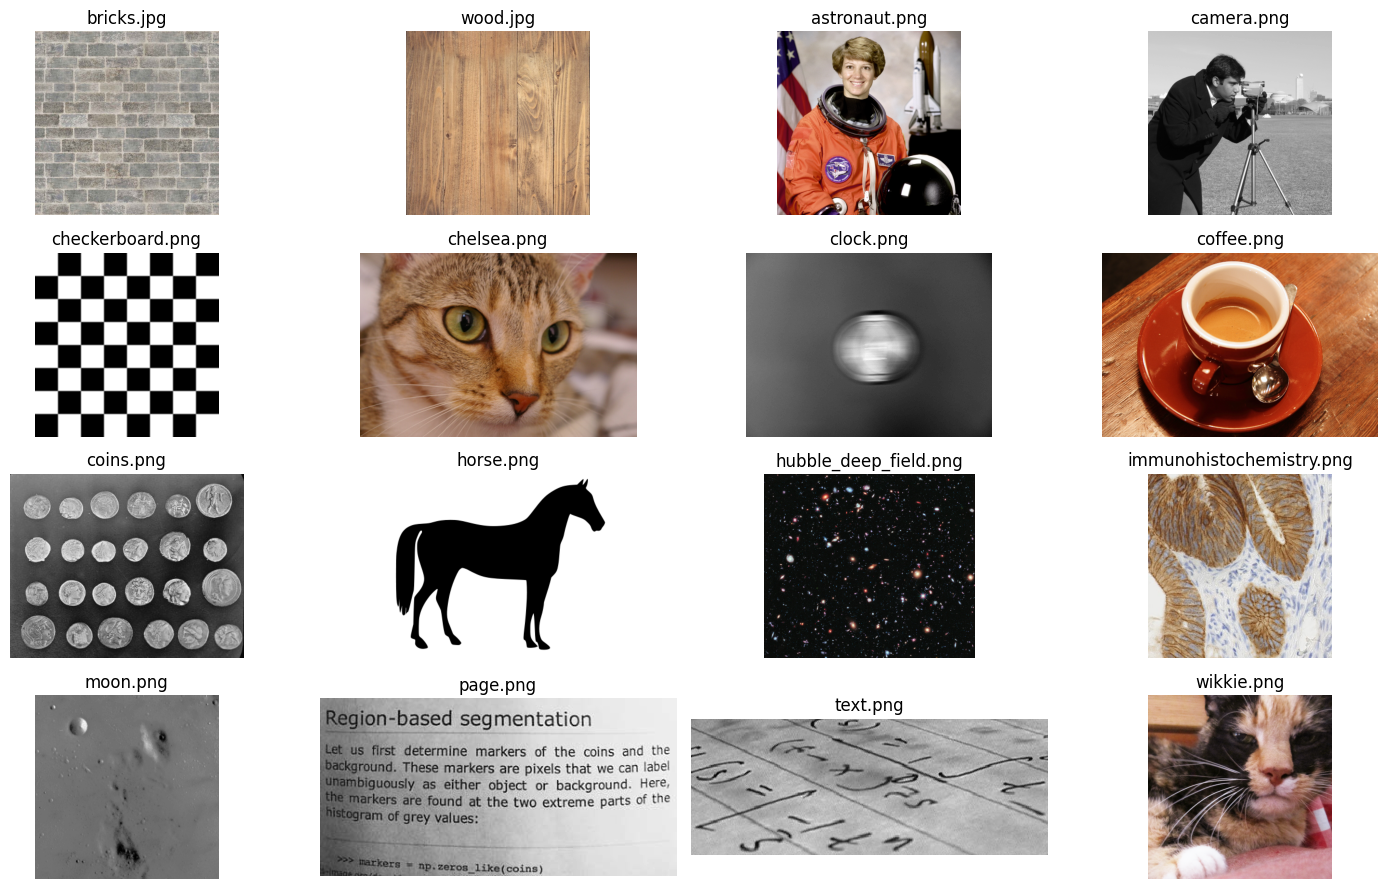

In [4]:
images_dict = {"bricks.jpg": None, "wood.jpg": None, "astronaut.png": None, "camera.png": None,
               "checkerboard.png": None, "chelsea.png": None, "clock.png": None, "coffee.png": None, "coins.png": None,
               "horse.png": None, "hubble_deep_field.png": None, "immunohistochemistry.png": None, "moon.png": None,
               "page.png": None, "text.png": None, "wikkie.png": None}

for key in images_dict.keys():
    images_dict[key] = iio.imread(f'imageio:{key}')

fig, axs = plt.subplots(4, 4, figsize=(15, 9))
for i, (key, value) in enumerate(images_dict.items()):
    ax = axs[i//4, i % 4]
    if value.ndim == 2:
        ax.imshow(value, cmap='gray')
    else:
        ax.imshow(value)
    ax.axis('off')
    ax.set_title(key)
plt.tight_layout()
plt.show()

# Ejercicio 1.1

La propuesta para esta actividad consiste en manipular independientemente la luminancia y la saturación de una imagen.
Para ello convertimos cada pixel de la imagen del espacio RGB al espacio YIQ, luego alteramos los valores de Y (para cambiar la luminancia) y/o de IQ (para cambiar la saturación).
Con los nuevos valores de YIQ, convertimos a RGB nuevamente y obtenemos una nueva imagen.

---

Lo primero que hacemos es cargar las matrices que nos permiten movernos entre los distintos espacios de color, y la función que nos ayuda a multiplicar matrices.


In [5]:
MAT_RGB2YIQ = np.array([[0.299, 0.587, 0.114],
                        [0.595716, -0.274453, -0.321263],
                        [0.211456, -0.522591, 0.311135]])

MAT_YIQ2RGB = np.array([[1.0, 0.9663, 0.6210],
                        [1.0, -0.2721, -0.6474],
                        [1.0, -1.1070, 1.7046]])


def apply_matrix(img, M):
    return np.matmul(img.reshape((-1, 3)), M.T).reshape(img.shape)

Con ello, definimos ahora la función que realiza lo pedido por el ejercicio:


In [6]:
def YIQ_modification(img, alpha, beta):
    img_rgb = img / 255

    img_yiq = apply_matrix(img_rgb, MAT_RGB2YIQ)

    img_yiq[..., 0] *= alpha    # alpha es el fator de afectacion de la luminancia
    img_yiq[..., 1:] *= beta    # beta es el fator de afectacion de la saturacion

    img_yiq[..., 0] = np.clip(img_yiq[..., 0], 0, 1)
    img_yiq[..., 1] = np.clip(img_yiq[..., 1], -0.5957, 0.5957)
    img_yiq[..., 2] = np.clip(img_yiq[..., 2], -0.5226, 0.5226)

    img_rgb = apply_matrix(img_yiq, MAT_YIQ2RGB)

    img_rgb = np.clip(img_rgb, 0, 1) * 255
    return img_rgb.astype(np.uint8)

Si nos concentramos en la imagen de _coffee_, podemos ver las siguientes posibles modificaciones realizadas de forma manual:


In [7]:
coffee_yiq_modifications = [
    (1, 1),
    (0.4, 1),
    (0.7, 1),
    (1.2, 1),
    (1.5, 1),
    (1, 0),
    (1, 0.5),
    (1, 1.2),
    (1, 1.5),
    (0.5, 0.5),
    (0.8, 0.8),
    (1.2, 1.2),
    (1.5, 1.5),
    (0.5, 1.5),
    (1.5, 0.5),
    (0.7, 1.2)]

fig, axs = plt.subplots(4, 4, figsize=(20, 20))
for i, (alpha, beta) in enumerate(coffee_yiq_modifications):
    img = YIQ_modification(images_dict['coffee.png'], alpha, beta)
    title = f'α={alpha}, β={beta}'

    ax = axs[i // 4, i % 4]
    ax.imshow(img)
    ax.set_title(title)
    ax.axis('off')

fig.suptitle('Modificaciones de la imagen "coffee.png" en el espacio YIQ', fontsize=20)
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

Sin embargo, otra posibilidad es crear una interacción con el usuario que le permita elegir la imagen que quiere cargar y los valores de luminancia y saturación que quiere modificar. Para ello, se puede utilizar la librería `ipywidgets` que permite crear widgets interactivos en Jupyter Notebook. **Elegir solo las figuras en colores (no en blanco, negro o grises)**


In [8]:
image_YIQ_modif = widgets.Dropdown(
    options=images_dict.keys(),
    description='Imagen:'
)
alpha_YIQ_modif = widgets.FloatSlider(
    value=1,
    min=0,
    max=2,
    step=0.05,
    description='Alpha:',
    readout_format='.2f',
)
beta_YIQ_modif = widgets.FloatSlider(
    value=1,
    min=0,
    max=2,
    step=0.05,
    description='Beta:',
    readout_format='.2f',
)


def button_YIQ():
    plt.imshow(YIQ_modification(images_dict[image_YIQ_modif.value], alpha_YIQ_modif.value, beta_YIQ_modif.value))
    plt.axis('off')
    plt.show()


do_YIQ_modification = widgets.Button(description='Do YIQ modification')
do_YIQ_modification.on_click(lambda _: button_YIQ())

widgets.VBox([image_YIQ_modif, alpha_YIQ_modif, beta_YIQ_modif, do_YIQ_modification])

# Ejercicio 1.2

Desarrollar un aplicativo o notebook que pueda abrir una imagen, manipule su histograma de luminancias, y luego ver la imagen procesada. Se debe poder elegir filtro raíz, cuadrado, o lineal a trozos.
Los controles para elegir los filtros los organizan como les resulte más cómodo.

---

Para ello, lo primero que vamos a hacer es definir la función que se encargue de realizar el cambio en el histograma de luminancias según los filtros.


In [9]:
def filter_modification(img, filter, **kwargs):
    img_rgb = img / 255
    img_yiq = apply_matrix(img_rgb, MAT_RGB2YIQ)
    img_Y = img_yiq[..., 0]

    match filter:
        case 'pow2':
            img_Y = np.power(img_Y, 2)
        case 'sqrt':
            img_Y = np.sqrt(img_Y)
        case 'piecewise_linear':
            min_Y, max_Y = kwargs['min_Y'], kwargs['max_Y']
            img_Y[img_Y < min_Y] = 0
            img_Y[img_Y > max_Y] = 1
        case _:
            raise ValueError('Invalid filter')

    img_yiq[..., 0] = img_Y
    img_rgb = apply_matrix(img_yiq, MAT_YIQ2RGB)
    img_rgb = np.clip(img_rgb, 0, 1) * 255
    return img_rgb.astype(np.uint8)

Ahora, podemos probar la función definida anteriormente con la imagen de _chelsea_ (el gato) de forma manual, y comprobar que funciona correctamente:


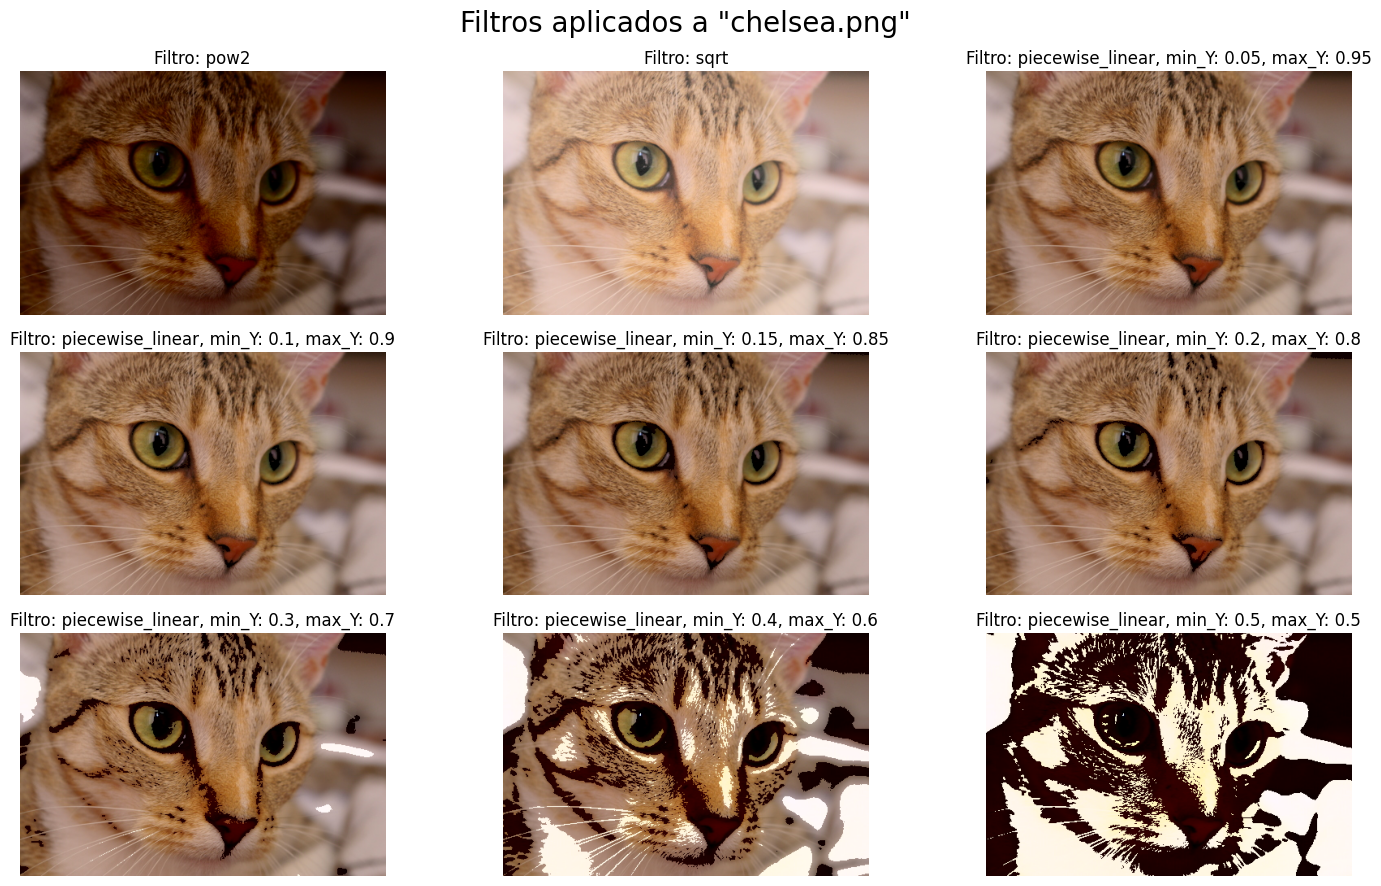

In [10]:
filter_modifications = [
    ('pow2', {}),
    ('sqrt', {}),
    ('piecewise_linear', {'min_Y': 0.05, 'max_Y': 0.95}),
    ('piecewise_linear', {'min_Y': 0.1, 'max_Y': 0.9}),
    ('piecewise_linear', {'min_Y': 0.15, 'max_Y': 0.85}),
    ('piecewise_linear', {'min_Y': 0.2, 'max_Y': 0.8}),
    ('piecewise_linear', {'min_Y': 0.3, 'max_Y': 0.7}),
    ('piecewise_linear', {'min_Y': 0.4, 'max_Y': 0.6}),
    ('piecewise_linear', {'min_Y': 0.5, 'max_Y': 0.5})
]

fig, axs = plt.subplots(3, 3, figsize=(15, 9))
for i, (filter, kwargs) in enumerate(filter_modifications):
    img = filter_modification(images_dict['chelsea.png'], filter, **kwargs)
    if filter == 'piecewise_linear':
        title = f'Filtro: {filter}, min_Y: {kwargs["min_Y"]}, max_Y: {kwargs["max_Y"]}'
    else:
        title = f'Filtro: {filter}'

    ax = axs[i // 3, i % 3]
    ax.imshow(img)
    ax.set_title(title)
    ax.axis('off')

fig.suptitle('Filtros aplicados a "chelsea.png"', fontsize=20)
plt.tight_layout()
plt.show()

Visto esto, implementamos el _aplicativo_ que permite al usuario elegir la foto y el filtro que quiere aplicar.


In [11]:
image_filter_modif = widgets.Dropdown(
    options=images_dict.keys(),
    description='Imagen:'
)
filter_modif_choice = widgets.Dropdown(
    options=['pow2', 'sqrt', 'piecewise_linear'],
    description='Filtro:'
)
min_Y_filter_modif = widgets.FloatSlider(
    value=0.05,
    min=0,
    max=1,
    step=0.05,
    description='Min Y:',
    readout_format='.2f',
)
max_Y_filter_modif = widgets.FloatSlider(
    value=0.95,
    min=0,
    max=1,
    step=0.05,
    description='Max Y:',
    readout_format='.2f',
)


def button_filter():
    plt.imshow(filter_modification(images_dict[image_filter_modif.value], filter_modif_choice.value,
                                   min_Y=min_Y_filter_modif.value, max_Y=max_Y_filter_modif.value))
    plt.axis('off')
    plt.show()


do_filter_modification = widgets.Button(description='Do filter modification')
do_filter_modification.on_click(lambda _: button_filter())

widgets.VBox([image_filter_modif, filter_modif_choice, min_Y_filter_modif, max_Y_filter_modif, do_filter_modification])

# Ejercicio 2.1

Implementar un aplicativo o notebook que levante una imagen en nivel de gris (o que la convierta a YIQ y retenga solo el Y) y aplique el filtrado por convolución aquí visto:

1. Pasabajos: Plano, Bartlett 3x3, Gaussiano 5x5.
2. Detectores de bordes: Laplaciano v4, Sobel 4 orientaciones.
3. Pasabanda.

Respecto del “cierre” de la imagen cerca de los bordes, implementar la técnica no ma- temáticamente perfecta de “repetir” artificialmente filas o columnas cuando estas hagan falta. Por ejemplo, si el kernel es 3x3 y estoy en la primera columna, y no hay ninguna columna a la izquierda, entonces repito la primera columna como si estuviese en la imagen original.

---

Lo primero que vamos a hacer es crear las funciones correspondientes a:

- Crear el filtro que necesitemos según lo marcado en el enunciado del ejercicio
- Aplicar la convolución a la imagen con el filtro seleccionado
- Pasar una imagen RGB a escala de grises

Con ello, podremos crear el aplicativo pedido.


In [12]:
def create_kernel(filter_name):
    match filter_name:
        case 'flat_3x3':
            kernel = np.full((3, 3), 1 / 9)
        case 'bartlett_3x3':
            kernel = np.array([1., 2., 1.])
            kernel = np.outer(kernel, kernel)
            kernel /= np.sum(kernel)
        case 'gaussian_5x5':
            kernel = np.array([1., 4., 6., 4., 1.])
            kernel = np.outer(kernel, kernel)
            kernel /= np.sum(kernel)
        case 'laplace_v4':
            kernel = np.zeros((3, 3))
            kernel[1, 1] = -1
            kernel = ndi.laplace(kernel)
        case 'sobel_north':
            kernel = np.zeros((3, 3))
            kernel[1, 1] = -1
            kernel = ndi.sobel(kernel, axis=0)
        case 'sobel_south':
            kernel = np.zeros((3, 3))
            kernel[1, 1] = 1
            kernel = ndi.sobel(kernel, axis=0)
        case 'sobel_west':
            kernel = np.zeros((3, 3))
            kernel[1, 1] = 1
            kernel = ndi.sobel(kernel, axis=1)
        case 'sobel_east':
            kernel = np.zeros((3, 3))
            kernel[1, 1] = -1
            kernel = ndi.sobel(kernel, axis=1)
        case 'band_pass':
            kernel_small = np.array([1., 2., 1.])
            kernel_small = np.outer(kernel_small, kernel_small)
            kernel_small /= np.sum(kernel_small)
            kernel_small = np.pad(kernel_small, 1)

            kernel_large = np.array([1., 4., 6., 4., 1.])
            kernel_large = np.outer(kernel_large, kernel_large)
            kernel_large /= np.sum(kernel_large)

            kernel = kernel_small - kernel_large
        case _:
            raise ValueError('Invalid filter')

    return kernel


def convolution(img, filter_name):
    kernel = create_kernel(filter_name)
    return ndi.convolve(img, kernel, mode='nearest')


def RGB_to_gray(img):
    if img.ndim == 2:
        return img

    img_rgb = img / 255
    img_yiq = apply_matrix(img_rgb, MAT_RGB2YIQ)
    return np.clip(img_yiq[..., 0], 0, 1)

Hecho esto, podemos probar "a mano" que funciona correctamente viendo las conversiones realizadas a la imagen "coins.png":


In [13]:
kernel_modifications = [
    'flat_3x3',
    'bartlett_3x3',
    'gaussian_5x5',
    'laplace_v4',
    'sobel_north',
    'sobel_south',
    'sobel_west',
    'sobel_east',
    'band_pass'
]

image_to_see = RGB_to_gray(images_dict['coins.png'])
plt.imshow(image_to_see, cmap='gray')
plt.title('Imagen en escala de grises')
plt.axis('off')

fig, axs = plt.subplots(3, 3, figsize=(20, 14))
for i, filter_name in enumerate(kernel_modifications):
    img = convolution(image_to_see, filter_name)

    ax = axs[i // 3, i % 3]
    ax.imshow(img, cmap='gray')
    ax.set_title(filter_name)
    ax.axis('off')

fig.suptitle('Convoluciones aplicadas a "coins.png"', fontsize=20)
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

Con ello, entonces, estamos listos para crear el aplicativo pedido:


In [14]:
image_kernel_modif = widgets.Dropdown(
    options=images_dict.keys(),
    description='Imagen:'
)
filter_kernel_modif = widgets.Dropdown(
    options=kernel_modifications,
    description='Filtro:'
)


def button_kernel():
    img = RGB_to_gray(images_dict[image_kernel_modif.value])
    plt.imshow(convolution(img, filter_kernel_modif.value), cmap='gray')
    plt.axis('off')
    plt.show()


do_kernel_modification = widgets.Button(description='Do kernel modification', layout=widgets.Layout(width='25%'))
do_kernel_modification.on_click(lambda _: button_kernel())

widgets.VBox([image_kernel_modif, filter_kernel_modif, do_kernel_modification])

# Ejercicio 2.2

Desarrollar un aplicativo o notebook que implemente los conceptos de morfología en niveles de gris aquí descriptos, con un elemento estructurante 3x3. El mismo incluirá las siguientes funciones:

- Erosión (tomar el mínimo valor de luminancia de la vecindad).
- Dilatación (máximo)
- Apertura, cierre, borde morfológico
- Mediana
- Top-hat

Incluir la capacidad de copiar la componente de la imagen procesada en la componente original, para poder aplicar dos o más filtrados en secuencia.

---

Lo primero que vamos a hacer es definir las funciones que nos permitan realizar las operaciones de morfología en niveles de gris.


In [15]:
def apply_morphological_filter(img, filter_name):
    kernel = np.ones((3, 3))
    img_processed = img
    match filter_name:
        case 'erosion':
            img_processed = cv2.erode(img, kernel, iterations=1)
        case 'dilation':
            img_processed = cv2.dilate(img, kernel, iterations=1)
        case 'opening':
            img_processed = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
        case 'closing':
            img_processed = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
        case 'gradient':
            img_processed = cv2.morphologyEx(img, cv2.MORPH_GRADIENT, kernel)
        case 'median':
            img_processed = cv2.medianBlur(img, 3)
        case 'top_hat':
            img_processed = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, kernel)

    return img_processed

Podemos probar las funciones definidas anteriormente con la imagen de _page.png_ de forma manual con el objetivo de comprobar que funcionan correctamente:


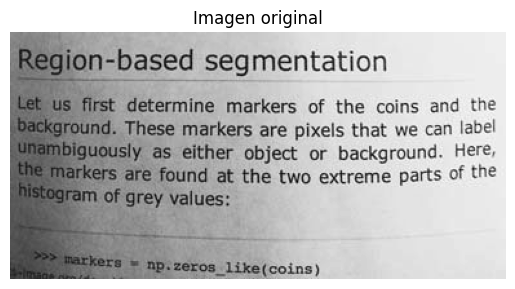

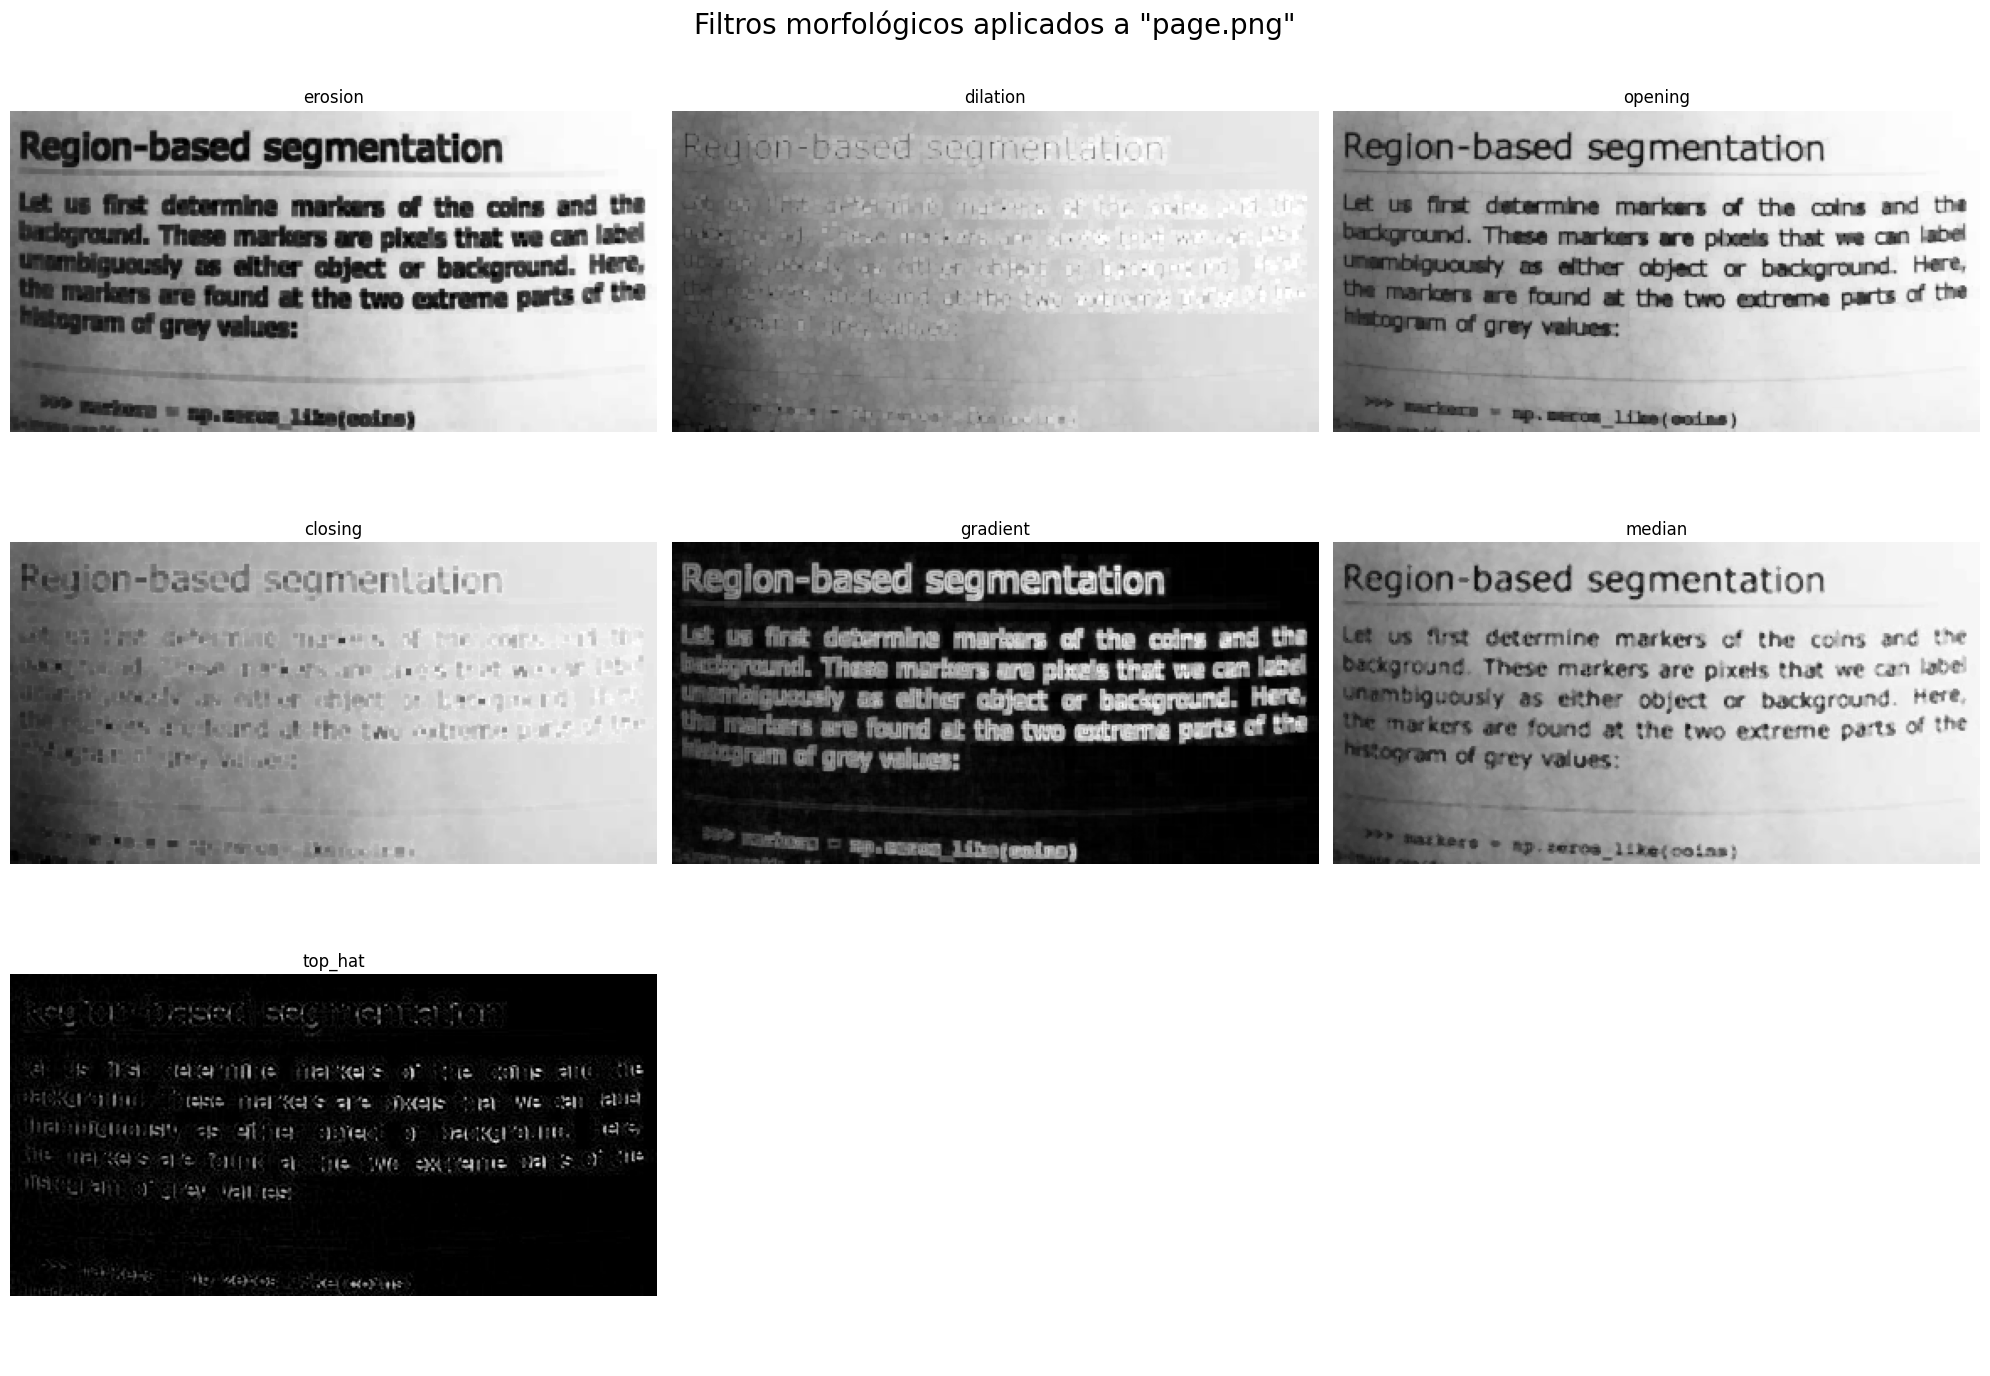

In [16]:
morphological_filters = [
    'erosion',
    'dilation',
    'opening',
    'closing',
    'gradient',
    'median',
    'top_hat'
]

image_to_see = images_dict['page.png']
plt.imshow(image_to_see, cmap='gray')
plt.title('Imagen original')
plt.axis('off')

fig, axs = plt.subplots(3, 3, figsize=(20, 14))
for i, filter_name in enumerate(morphological_filters):
    img = apply_morphological_filter(image_to_see, filter_name)

    ax = axs[i // 3, i % 3]
    ax.imshow(img, cmap='gray')
    ax.set_title(filter_name)
    ax.axis('off')
for j in range(i + 1, 9):
    axs[j // 3, j % 3].axis('off')

fig.suptitle('Filtros morfológicos aplicados a "page.png"', fontsize=20)
plt.tight_layout()
plt.show()

Ahora, implementamos el aplicativo que permite al usuario elegir la imagen y la operación de morfología que quiere aplicar.


In [17]:
image_morphological_modif = widgets.Dropdown(
    options=images_dict.keys(),
    description='Imagen:'
)

filter_morphological_modif = widgets.Dropdown(
    options=morphological_filters,
    description='Filtro:'
)


def button_morphological():
    plt.imshow(
        apply_morphological_filter(
            images_dict[image_morphological_modif.value],
            filter_morphological_modif.value),
        cmap='gray')
    plt.axis('off')
    plt.show()


do_morphological_modification = widgets.Button(
    description='Do morphological modification', layout=widgets.Layout(width='25%'))
do_morphological_modification.on_click(lambda _: button_morphological())

widgets.VBox([image_morphological_modif, filter_morphological_modif, do_morphological_modification])

# Ejercicios Optativos.

## Ejercicio 1.3 (optativo) Cambio de paletas cromáticas en una imagen

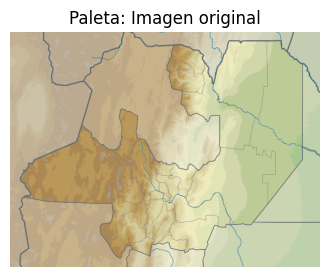

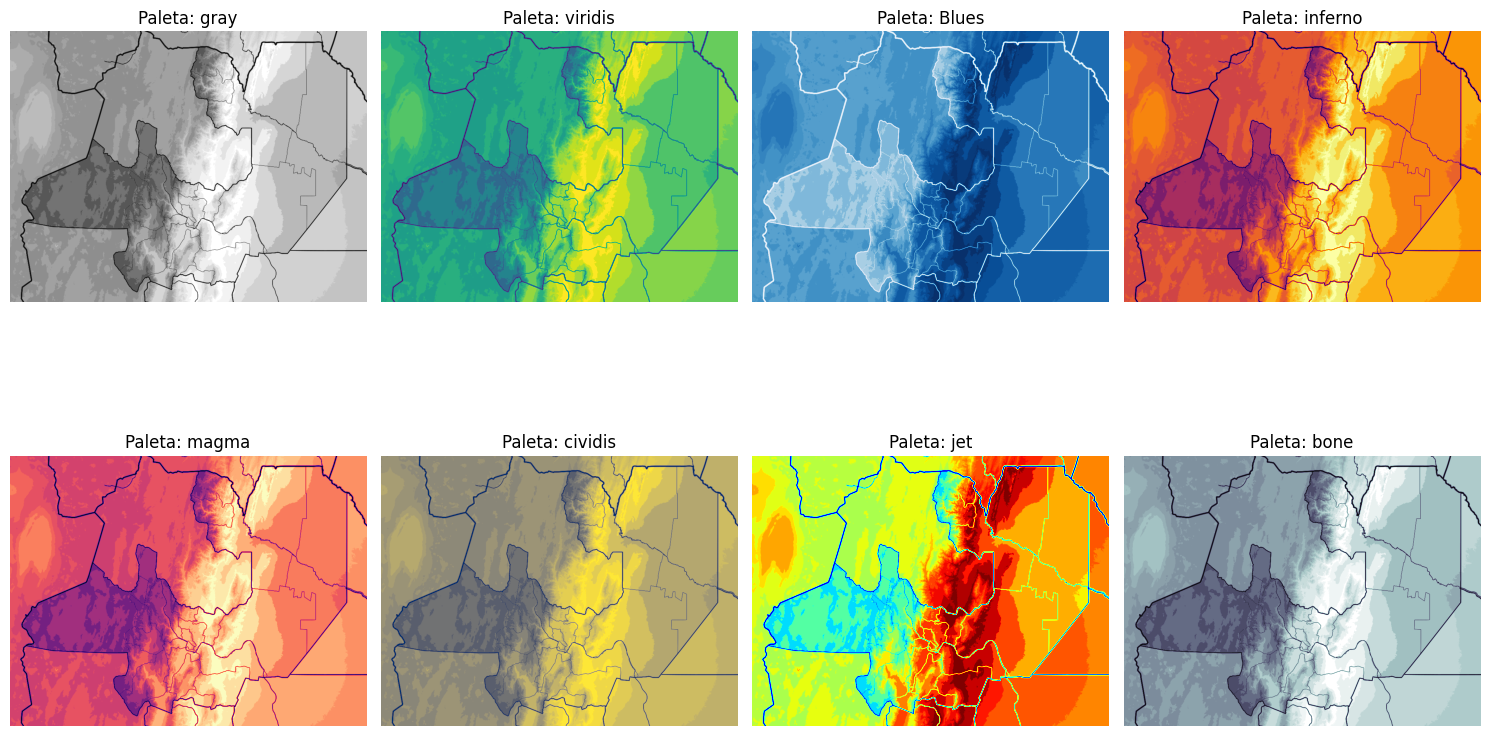

(768, 1013)


In [18]:
from PIL import Image

# Paso 1: Leer la imagen

imagen = Image.open('/content/drive/MyDrive/proc_imag/Salta_topographic.png')
imagen_gray = imagen.convert("L")  # "L" es el modo de escala de grises
# Convertir la imagen original a un array de numpy
imagen_orig_array=np.array(imagen)
# Convertir la imagen gris a un array de numpy
imagen_array = np.array(imagen_gray)

plt.figure(figsize=(4,4))
plt.imshow(imagen)
plt.title(f'Paleta: Imagen original')
plt.axis('off')

# Definir las diferentes paletas de colores (colormaps)
colormaps = ['gray', 'viridis', 'Blues', 'inferno', 'magma', 'cividis', 'jet', 'bone']

# Crear un gráfico con varias subgráficas (para mostrar las diferentes paletas)
fig, axes = plt.subplots(2, 4, figsize=(15, 10))  # 2 filas y 4 columnas

# Iterar sobre los colormaps y mostrarlos en el gráfico
for ax, cmap in zip(axes.ravel(), colormaps):
    cax = ax.imshow(imagen_array, cmap=cmap)  # Mostrar la imagen con el colormap
    ax.set_title(f"Paleta: {cmap}")
    ax.axis('off')  # Desactivar los ejes para mejor visualización
    #fig.colorbar(cax, ax=ax)  # Agregar la barra de colores

# Ajustar el diseño y mostrar la imagen
plt.tight_layout()
plt.show()
print(imagen_array.shape)


## Ejercicio 1.4 (optativo) Adecuación de tamaños y suma de imágenes

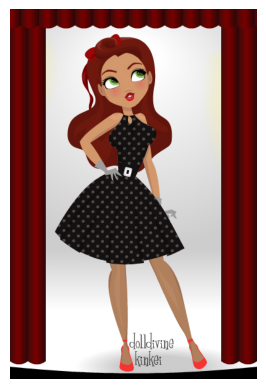

In [19]:
imag_doll=Image.open('/content/drive/MyDrive/proc_imag/DollDivine.jpg')
plt.imshow(imag_doll)
plt.axis('off')
plt.show()

Dadas dos imágenes, con la siguiente función se efectúa la suma. En el caso en que tengan diferente tamaño (shape) se efectúan las dos sumas posibles, mediante resizing.

In [20]:
def suma_imagenes (imagen_1,imagen_2):
    imagen_1_array=np.array(imagen_1,dtype=np.uint8)
    imagen_2_array=np.array(imagen_2,dtype=np.uint8)
    if imagen_1_array.shape == imagen_2_array.shape:
        suma=np.clip(imagen_1_array+imagen_2_array,0,255)
        print('hay una unica opcion para la suma de imagenes')
        plt.imshow(suma)
        plt.title('Suma de imagenes')
        plt.axis('off')
        plt.show()
    else:
        print('Hay dos opciones para la suma de imágenes ya que tienen distinto tamaño')
        # llevo imagen_1 al tamaño de imagen_2
        imagen_1_resized=imagen_1.resize(imagen_2.size)
        imagen_1_resized_array=np.array(imagen_1_resized,dtype=np.uint8)
        plt.imshow(np.clip(imagen_1_resized_array+imagen_2_array,0,255))
        plt.axis('off')
        plt.show()
        # llevo imagen_2 al tamaño de imagen_1
        imagen_2_resized=imagen_2.resize(imagen_1.size)
        imagen_2_resized_array=np.array(imagen_2_resized,dtype=np.uint8)
        plt.imshow(np.clip(imagen_2_resized_array+imagen_1_array,0,255))
        plt.axis('off')
        plt.show()
    return

Hay dos opciones para la suma de imágenes ya que tienen distinto tamaño


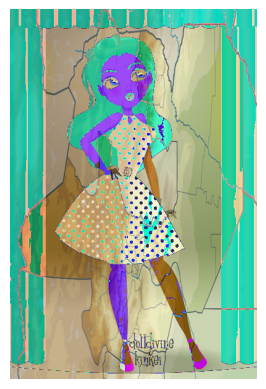

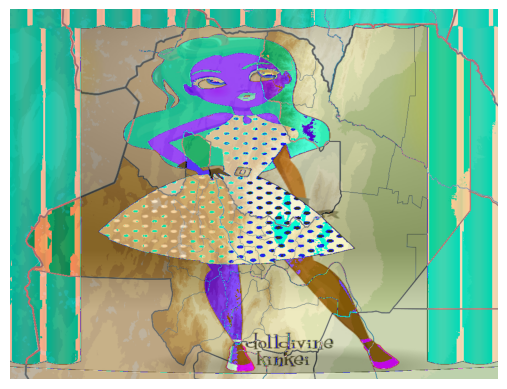

In [21]:
suma_imagenes (imagen,imag_doll)

# Ejercicio 2.3 (optativo)

Desarrollar un aplicativo o notebook que implemente las siguientes funciones:

•Downsampling X2 (mostrando la imagen resultado al doble de tamaño para comparar el efecto) utilizando kernel constante, bilineal, y bicúbico.

•Upsampling X2 (mostrando la imagen original al doble de tamaño para comparar el efecto) utilizando kernel constante, bilineal, y bicúbico.

•Cuantización a cantidad de niveles de gris variable, utilizando uniforme, dithering aleatorio, y difusión del error por scan-line.

---



Primero se crea una función que permita diferenciar entre imagenes RGB y escala de grises para poder aplicar lo métodos apropiadamente.

In [22]:
# Función para ajustar la imagen según su formato (RGB o escala de grises)
def prepare_image(image):
    "Prepara la imagen para el procesamiento, asegurando compatibilidad con escala de grises o RGB."
    if image.ndim == 2:  # Imagen en escala de grises
        return image, 'gray'
    elif image.shape[2] == 3:  # Imagen RGB
        return image, None  # No es necesario cmap para RGB
    else:
        raise ValueError("Formato de imagen no compatible. La imagen debe ser RGB o escala de grises.")

Se crean las funciones de downsampling, upsampling y cuantización con sus 3 métodos correspondientes.

In [23]:
# Funciones ajustadas para downsampling y upsampling
def downsampling(image, method):
    factor = 0.5
    order = {'nearest': 0, 'bilinear': 1, 'bicubic': 3}.get(method, 1)
    downsampled = rescale(
        image, scale=factor, order=order, anti_aliasing=True, channel_axis=-1 if image.ndim == 3 else None, preserve_range=True
    ).astype(np.uint8)
    return downsampled

def upsampling(image, method):
    factor = 2
    order = {'nearest': 0, 'bilinear': 1, 'bicubic': 3}.get(method, 1)
    upsampled = rescale(
        image, scale=factor, order=order, anti_aliasing=False, channel_axis=-1 if image.ndim == 3 else None, preserve_range=True
    ).astype(np.uint8)
    return upsampled

# Funciones de cuantización que funcionan para escala de grises o RGB
def quantize_uniform(image, levels):
    step = 255 // (levels - 1)
    quantized = (image // step) * step
    return quantized.astype(np.uint8)

def quantize_dithering_random(image, levels):
    step = 255 // (levels - 1)
    noise = np.random.randint(-step // 2, step // 2 + 1, size=image.shape)
    dithered = np.clip(image + noise, 0, 255)
    quantized = (dithered // step) * step
    return quantized.astype(np.uint8)

def quantize_error_diffusion(image, levels):
    step = 255 / (levels - 1)
    error_diffused = image.copy().astype(np.float32)

    for y in range(error_diffused.shape[0]):
        for x in range(error_diffused.shape[1]):
            old_pixel = error_diffused[y, x]
            new_pixel = np.round(old_pixel / step) * step
            error_diffused[y, x] = new_pixel
            quant_error = old_pixel - new_pixel

            if x + 1 < error_diffused.shape[1]:
                error_diffused[y, x + 1] += quant_error * 7 / 16
            if y + 1 < error_diffused.shape[0]:
                if x > 0:
                    error_diffused[y + 1, x - 1] += quant_error * 3 / 16
                error_diffused[y + 1, x] += quant_error * 5 / 16
                if x + 1 < error_diffused.shape[1]:
                    error_diffused[y + 1, x + 1] += quant_error * 1 / 16

    return np.clip(error_diffused, 0, 255).astype(np.uint8)

Se implementan las funciones en el aplicativo y se establece un nivel de zoom de manera que se aprecie mejor los cambios que realizan el downsampling y el upsampling.

In [24]:
# Widgets para seleccionar imagen, método y niveles de cuantización
image_selector = widgets.Dropdown(
    options=list(images_dict.keys()),
    description='Imagen:',
    value=list(images_dict.keys())[0]
)

method_selector = widgets.Dropdown(
    options=['nearest', 'bilinear', 'bicubic'],
    description='Método de Escala:',
    value='nearest'
)

levels_slider = widgets.IntSlider(
    value=4,
    min=2,
    max=64,
    step=2,
    description='Niveles de Cuantización:',
    continuous_update=False
)

# Contenedor de salida para mostrar la imagen
output = widgets.Output()

# Función para visualizar las transformaciones
def apply_transformations(_):
    with output:
        output.clear_output()
        image = images_dict[image_selector.value]
        method = method_selector.value
        levels = levels_slider.value

        # Preparar imagen y determinar el cmap según su formato
        image, cmap = prepare_image(image)

        # Aplicar downsampling y upsampling
        downsampled_image = downsampling(image, method)
        upsampled_image = upsampling(image, method)

        # Aplicar cuantización
        quantized_uniform = quantize_uniform(image, levels)
        quantized_dithering = quantize_dithering_random(image, levels)
        quantized_error_diffusion = quantize_error_diffusion(image, levels)

        # Visualización de todas las transformaciones con zoom
        fig, axs = plt.subplots(3, 3, figsize=(15, 12))

        # Primera fila: imagen original y downsampling/upsampling
        axs[0, 0].imshow(image, cmap=cmap, interpolation=method)
        axs[0, 0].set_title("Imagen Original")
        axs[0, 0].axis('off')

        axs[0, 1].imshow(downsampled_image, cmap=cmap, interpolation=method)
        axs[0, 1].set_title(f'Downsampling X2 ({method})')
        axs[0, 1].axis('off')

        axs[0, 2].imshow(upsampled_image, cmap=cmap, interpolation=method)
        axs[0, 2].set_title(f'Upsampling X2 ({method})')
        axs[0, 2].axis('off')

        # Segunda fila: zoom en el centro de las imágenes downsampled y upsampled
        axs[1, 0].imshow(image, cmap=cmap, interpolation=method)
        axs[1, 0].set_title("Zoom de Imagen Original")
        axs[1, 0].set_xlim(image.shape[1] / 4, 3 * image.shape[1] / 4)
        axs[1, 0].set_ylim(3 * image.shape[0] / 4, image.shape[0] / 4)  # invertir para orientación
        axs[1, 0].axis('off')

        axs[1, 1].imshow(downsampled_image, cmap=cmap, interpolation=method)
        axs[1, 1].set_title("Zoom de Downsampling")
        axs[1, 1].set_xlim(downsampled_image.shape[1] / 4, 3 * downsampled_image.shape[1] / 4)
        axs[1, 1].set_ylim(3 * downsampled_image.shape[0] / 4, downsampled_image.shape[0] / 4)
        axs[1, 1].axis('off')

        axs[1, 2].imshow(upsampled_image, cmap=cmap, interpolation=method)
        axs[1, 2].set_title("Zoom de Upsampling")
        axs[1, 2].set_xlim(upsampled_image.shape[1] / 4, 3 * upsampled_image.shape[1] / 4)
        axs[1, 2].set_ylim(3 * upsampled_image.shape[0] / 4, upsampled_image.shape[0] / 4)
        axs[1, 2].axis('off')

        # Tercera fila: Cuantización uniforme, dithering y difusión de error
        axs[2, 0].imshow(quantized_uniform, cmap=cmap, interpolation=method)
        axs[2, 0].set_title(f'Cuantización Uniforme - {levels} niveles')
        axs[2, 0].axis('off')

        axs[2, 1].imshow(quantized_dithering, cmap=cmap, interpolation=method)
        axs[2, 1].set_title(f'Dithering Aleatorio - {levels} niveles')
        axs[2, 1].axis('off')

        axs[2, 2].imshow(quantized_error_diffusion, cmap=cmap, interpolation=method)
        axs[2, 2].set_title(f'Difusión de Error - {levels} niveles')
        axs[2, 2].axis('off')

        plt.tight_layout()
        plt.subplots_adjust(wspace=0.05, hspace=0.3)
        plt.show()


# Botón para aplicar las transformaciones
apply_button = widgets.Button(description='Aplicar Transformaciones')
apply_button.on_click(apply_transformations)

# Organizar los widgets y el contenedor de salida
ui = widgets.VBox([
    image_selector,
    method_selector,
    levels_slider,
    apply_button,
    output
])

display(ui)